# 雲天による遮光率のモデリング
- 雲は日光を遮る．衛星画像によって遮光率の値が分かっていると仮定しこれを統計モデルによって再現する．
    - 遮光率１：完全に雲
    - 遮光率０：晴天
- 1次元の疑似データを生成する
    - 混合数 3
    - ガウス分布の平均・分散パラメータ $\mu = \{2, 5, 8\} , \sigma^{2} = \{1, 1, 1\}$
    - 混合比 $\pi = \{0.3, 0.5, 0.2\}$
    - シグモイド係数　$a, b$ 
        - $\mathrm{sigmoid}(z) = \frac{1}{1+\exp{(-z)}}, z=ax +b$
    - 疑似データ $f(x) = u\left( \sum_{i} \pi_{i}\mathcal{N}(x ; \mu_{i}, \sigma_{i}^{2}) \right), u(x) = \mathrm{sigmoid(x)}$
- ガウス混合分布に対してシグモイド関数による変換を施すことで値を[0, 1]に収める
- 推定の設定
    - ガウス分布の混合数は既知とする
- 推定パラメータ
    - ガウス分布の平均・分散パラメータ　$ \mu, \sigma$
    - 混合比の重み $\pi$
    - シグモイドの係数 $a, b$

In [242]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image
from scipy.stats import multivariate_normal

np.random.seed(1)

%matplotlib inline 

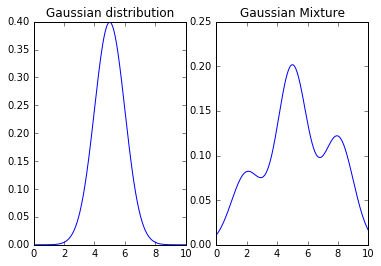

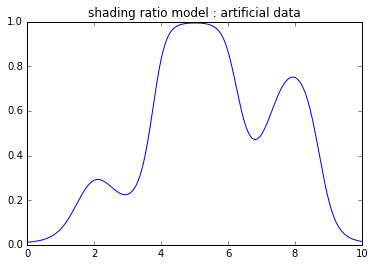

[[ 0.          0.01        0.02        0.03        0.04      ]
 [ 0.0114296   0.01155321  0.01168001  0.01181011  0.01194359]]


In [246]:
# generate 1-dimensional artificial data
x = np.arange(0, 10, 0.01)

# true parameter value
muTrue = np.array([2, 5, 8])
sigmaTrue = np.array([1. ,1. ,1. ])
piTrue = np.array([0.2, 0.5, 0.3])
aTrue = 50
bTrue = -5

# normal distribution density
def dnorm(x, mu, sigma):
    return((1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x-mu)**2/(2*sigma**2)))

plt.subplot(121)
plt.plot(x, dnorm(x, 5, 1))
plt.title('Gaussian distribution')

# Gaussian Mixture density
def dnorm_Mixture(x, mu, sigma, pi):
    values = dnorm(x, mu, sigma)
    return(sum(pi*values))

y = []
for i in x:
    y.append(dnorm_Mixture(i, mu=muTrue, sigma = sigmaTrue, pi = piTrue))
    
plt.subplot(122)
plt.plot(x,  y)
plt.title('Gaussian Mixture')
plt.show()

# logistic sigmoid function
def sigmoid(z):
    return(1/(1+np.exp(-z)))

# shading ratio model
def ShadeTrue(x, mu, sigma, pi, a, b):
    z = a * dnorm_Mixture(x, mu, sigma, pi) +b
    return(sigmoid(z))

y = []
for i in x:
    y.append(ShadeTrue(i, mu=muTrue, sigma=sigmaTrue, pi = piTrue, a=aTrue, b=bTrue))
    
plt.plot(x, y)
plt.title('shading ratio model : artificial data')
plt.show()

# generate artificial data
data = np.vstack((x, y))
print(data[:,0:5])

In [5]:
# initialize parameters to be estimated
muInit = np.array([2. ,5. ,8. ])
sigmaInit = np.array([1.,1.,1.])
piInit = np.array([0.33, 0.33, 0.33])

# descrepancy function : Bregman divergence
def Bregman_divergence(x, f, mu, sigma, pi, a, b):
    q = []
    for i in x:
        q.append(ShadeModel(x = i, mu =mu, sigma=sigma, pi = pi, a=a, b=b))
    q = np.array(q)

    descrepancy = 1./a * np.log((1.0-f)/(1.0-q)) - (1.0-f)/a *(np.log(q*(1.0-f)/(f*(1.0-q))))
    return(np.mean(descrepancy))

# Gradiend descent
def GradientDescent(parameter, LearningRate, gradient):
    newparameter = parameter - LearningRate *gradient
    return(newparameter)



In [254]:
class ShadeModel:
    
    # initialize variable
    # input_size : number of data point
    # input_lim : defined area limit, 1D -> [x], 2D->[x, y]
    # mixture_size : number of mixture
    # logistic coef : given logistic coefficient a, b, (z=ax+b)
    def __init__(self, input_size, input_lim,  mixture_size, logistic_coefficient):
        self.dimension = len(input_lim)
        
        self.params = {}
        '''
        self.params['mus'] = muTrue
        self.params['covs'] = sigmaTrue**2
        self.params['pi'] = piTrue
        '''
        self.params['mus'] = np.random.rand(mixture_size, self.dimension)*input_lim
        
        tmp = np.identity(self.dimension)
        tmp = np.tile(tmp, (mixture_size, 1))
        cov = tmp*input_lim
        self.params['covs'] = cov.reshape(mixture_size, self.dimension**2)
        
        weight = np.ones(mixture_size)
        self.params['pi'] = weight/sum(weight)
        
        self.params['ab'] = logistic_coefficient
        
    def dnormMulti(self, x, mu, cov):
        x = np.matrix(x)
        mu = np.matrix(mu)
        cov = np.matrix(cov.reshape(len(mu), len(mu)))
        dnmulti = multivariate_normal(mean = mu, cov=cov)
        return(dnmulti.pdf(x))
    
    def dnormMixture(self, x, mus, covs, pi):
        values = np.zeros(len(mus))
        for i in range(len(pi)):
            values[i] = self.dnormMulti(x, mus[i, :], covs[i , :])
        return(sum(pi*values))
    
    def sigmoid(self, z):
        return(1/(1+np.exp(-z)))
        
    def predict(self, x):
        mus = self.params['mus'].reshape(mixture_size, self.dimension)
        covs = self.params['covs'].reshape(mixture_size, self.dimension**2)
        pi = self.params['pi']
        a, b = self.params['ab']
        
        q = self.dnormMixture(x, mus = mus, covs = covs, pi = pi)
        g = self.sigmoid(a*q + b)
        return(g)
    
    
        

(1000,)


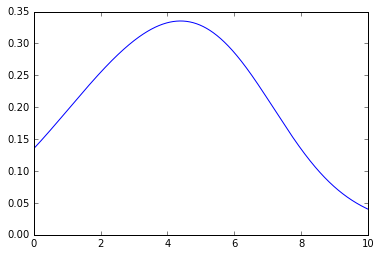

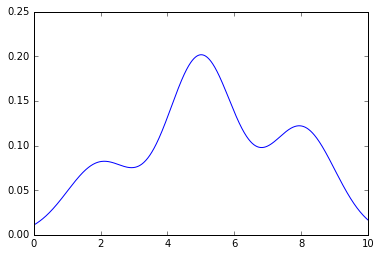

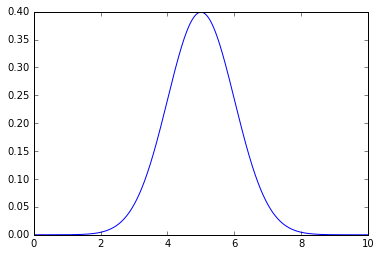

In [255]:
print(x.shape)
Model = ShadeModel(input_size=1000., input_lim=[10], mixture_size=3, logistic_coefficient=[50, -5])
g = np.zeros(len(x))
q = np.zeros(len(x))
q0 = np.zeros(len(x))
for i in range(len(x)):
    g[i] = Model.predict(x[i])
     
plt.plot(x, g)
plt.show()
plt.plot(x, q)
plt.show()
plt.plot(x, q0)
plt.show()



In [262]:
x = np.arange(0, 10, 0.01)
mus = np.array([2,5,8])
covs=np.array([1,1,1])
pi = np.array([0.33, 0.33, 0.33])
def dnmix(mus, covs): 
    norms = {}
    for i in range(len(pi)):
        norms[str(i)] = multivariate_normal(mean = mus[i], cov = covs[i])
    return(norms)

model = dnmix(mus = mus, covs = covs)
print(model['1'])

In [114]:

input_lim = np.array([100, 200, 100])
mixture_size = 3
input_dimension = len(input_lim)

tmp = np.random.rand(mixture_size, input_dimension)*input_lim
print(tmp)

tmp = np.identity(input_dimension)
tmp = np.tile(tmp, (mixture_size, 1))
print(tmp)

scale = input_lim.reshape(1, input_dimension)

cov = tmp*input_lim

print(cov)

print(cov.reshape(mixture_size, input_dimension**2))


weight = np.ones(mixture_size)
print(weight/sum(weight))

[[  94.75489414   44.28654686   26.70720197]
 [   8.14739649   85.72376573   10.9018764 ]
 [  63.37867606  160.59264747   69.68004961]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[ 100.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  100.]
 [ 100.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  100.]
 [ 100.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  100.]]
[[ 100.    0.    0.    0.  200.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.  200.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.  200.    0.    0.    0.  100.]]
[ 0.33333333  0.33333333  0.33333333]


In [245]:
x = np.array([[0], [1], [-1]])
print(x)
mu = np.array([0])
cov = np.identity(1)
print(mu, cov)

a, b = np.array([1,2])
print(a, b)

print(x.shape)

[[ 0]
 [ 1]
 [-1]]
[0] [[ 1.]]
1 2
(3, 1)


In [127]:
def dnormMulti(x, mu, cov):
    dimension = len(mu)
    x = np.matrix(x)
    mu = np.matrix(mu)
    cov = np.matrix(cov)
    tmp1 = np.sqrt(np.linalg.det(cov)*(2 * np.pi)**cov.ndim)
    tmp2 = np.linalg.det(-0.5*(x-mu)*cov.I*(x-mu).T)
    return(np.exp(tmp2)/tmp1)

[ 2.  5.  8.] [ 1.  1.  1.] [ 0.33  0.33  0.33] 5.0 0.0


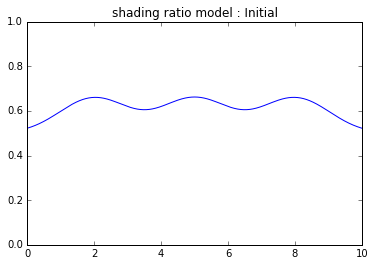

[ 1.99958305  4.99984443  8.00052726] [ 0.9997691   1.00089964  1.0003584 ] [ 0.33130559  0.32523627  0.32836997] 4.945736245 -0.0175861974888


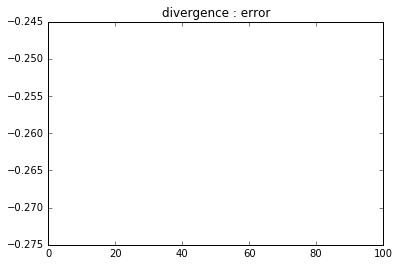

[ 1.99127098  4.99719693  8.01027939] [ 0.99480988  1.01584767  1.00667314] [ 0.3659085   0.24253037  0.3060993 ] 3.47232936285 -0.182616221359


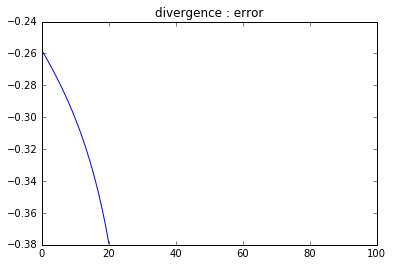

[ 1.98347395  4.99503564  8.01848745] [ 0.98464862  1.02687779  1.00956852] [ 0.43590399  0.19019988  0.31502862] -13.2412208063 -0.120120601756


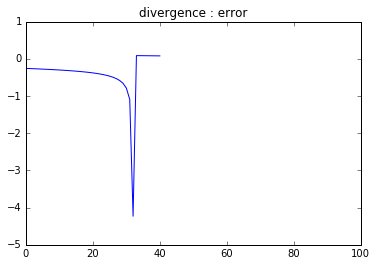

[ 1.97547182  4.99278331  8.02633274] [ 0.96412339  1.03737195  1.00805174] [ 0.56614905  0.1827436   0.37488764] -13.4046185456 -0.659071273379


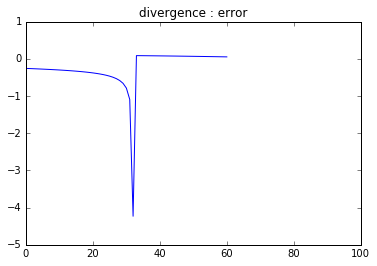

[ 1.9652921   4.99059381  8.03568936] [ 0.94119418  1.04773909  1.00663719] [ 0.70909093  0.19318373  0.45072706] -13.5489745231 -1.31333127943


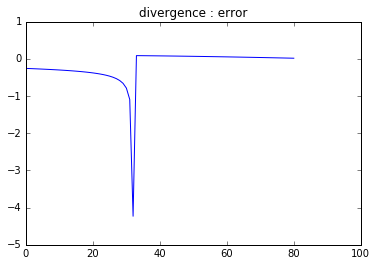

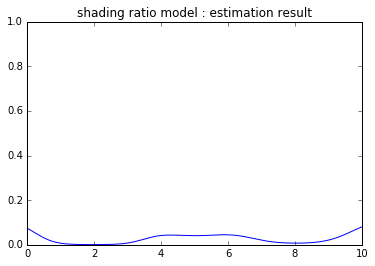

In [9]:
# iteration time
iterate = range(100)
mu = muInit
sigma = sigmaInit
pi = piInit
a = aInit
b = bInit
print(mu, sigma, pi, a, b)


InitModel = []
for i in data[0, :]:
    InitModel.append(ShadeModel(i, mu=mu, sigma=sigma, pi=pi, a=a, b=b))

plt.plot(data[0, :], InitModel)
plt.ylim([0, 1])
plt.title('shading ratio model : Initial')
plt.show()


# little value for numerical defferentiation
h = 1e-4

# divergence
Div = []

for i in iterate:
    # learning rate : 1/t anealed
    EtaMu = 0.1
    EtaSigma = 0.1
    EtaPi = 0.1
    EtaA = 1.0
    EtaB = 1.0
    
    
    # update mu
    grad = np.zeros(len(mu))
    for idx in range(len(mu)):
        tmp = mu[idx]
        mu[idx] = tmp+h
        Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        mu[idx] = tmp-h
        Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        grad[idx] = (Divf - Divb)/(2*h)
        mu[idx] = tmp
    # print(grad)
    mu = GradientDescent(parameter=mu, LearningRate=EtaMu, gradient = grad)
    
    # update sigma
    grad = np.zeros(len(sigma))
    for idx in range(len(sigma)):
        tmp = sigma[idx]
        sigma[idx] = tmp +h
        Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        sigma[idx] = tmp -h
        Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        grad[idx] = (Divf - Divb)/(2*h)
        sigma[idx] = tmp
    # print(grad)
    sigma = GradientDescent(parameter=sigma, LearningRate=EtaSigma, gradient=grad)
    
    # update pi
    grad = np.zeros(len(pi))
    for idx in range(len(pi)):
        tmp = pi[idx]
        pi[idx] = tmp+h
        Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        pi[idx] = tmp-h
        Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
        grad[idx] = (Divf - Divb)/(2*h)
        pi[idx] = tmp
    # print(grad)
    pi = GradientDescent(parameter=pi, LearningRate=EtaPi, gradient=grad)
    
    # update a
    Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a+h, b=b)
    Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a-h, b=b)
    gradient = (Divf - Divb)/(2*h)
    # print(gradient)
    a = GradientDescent(parameter=a, LearningRate=EtaA, gradient=gradient)
    
    # update b
    Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b+h)
    Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b-h)
    gradient = (Divf - Divb)/(2*h)
    # print(gradient)
    b = GradientDescent(parameter=b, LearningRate=EtaB, gradient=gradient)
    
    Div.append(Bregman_divergence(x=data[0, : ], f = data[1, :], mu=mu, sigma = sigma, pi = pi, a = a, b = b))
    
    if(i % 20 ==0):
        print(mu, sigma, pi, a, b)
        plt.plot(range(len(Div)), Div)
        plt.xlim([0, len(iterate)])
        plt.title('divergence : error')
        plt.show()
        
    
        
Result = []
for i in data[0, :]:
    Result.append(ShadeModel(x = i, mu =mu, sigma=sigma, pi = pi, a=a, b=b))
    
plt.plot(data[0, :], Result)
plt.ylim([0, 1])
plt.xlim([0,10])
plt.title('shading ratio model : estimation result')
plt.show()

In [72]:
mu = muInit
sigma = np.array([2.,2.,2.])
pi = piInit
a = aInit
b = bInit
data[0:2, 0:5]
idx = 0

print(sigma)
grad = np.zeros(3)
tmp = sigma[idx]
print(tmp)
sigma[idx] = tmp +h
print(tmp, h, tmp+h , sigma[idx])
Divf = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
print(idx, Divf, tmp, h, tmp-h)
sigma[idx] = tmp -h
print(sigma[idx])
Divb = Bregman_divergence(x = data[0, : ], f = data[1,: ], mu=mu, sigma=sigma, pi = pi, a = a, b=b)
grad[idx] = (Divf - Divb)/(2*h)

[ 2.  2.  2.]
2.0
2.0 0.0001 2.0001 2.0001
0 -0.250428506414 2.0 0.0001 1.9999
1.9999


In [10]:
Div[0:5]

[-0.25814115380178271,
 -0.26178932287542378,
 -0.26553599187579729,
 -0.2693953733412352,
 -0.27338291243910323]